# Example 004 - load and process data from Nikon N-SIM instrument
  


### Import libraries

In [1]:
import numpy as np
from numpy import fft
from pathlib import Path
import mcsim.analysis.sim_reconstruction as sim
from mcsim.analysis import analysis_tools
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import napari
import nd2

### Define data path

In [2]:
nd2_path = Path("data", "example_004", "raw_data", "neurocyte_lab_NSIM_data.nd2")

### Parse raw Nikon N-SIM data

In [3]:
# Nikon 2D SIM phases and angles
n_phases = 3
n_angles = 3

# open ND2File
try:
    f = nd2.ND2File(nd2_path)
except:
    raise Exception('Cannot open specified file.')
    
# extract total image size
# in N-SIM data, all 9 images are in one giant tiled image.
# rows are angles, columns are phases
height_pixels = f.attributes.heightPx
width_pixels = f.attributes.widthPx

# determine individual image size
n_ypixels = int(height_pixels/n_angles)
n_xpixels = int(height_pixels/n_phases)

# extract experiment metadata
sizes = f.sizes
try:
    n_channels = int(sizes['C'])
except:
    n_channels = 1
try:
    n_z_steps = int(sizes['Z'])
except:
    n_z_steps = 1  

# extract per channel metadata
wvl_ch_um = np.zeros(n_channels)
NA_ch = np.zeros(n_channels)
RI_ch = np.zeros(n_channels)
pixel_size_ch_um = np.zeros([n_channels,3])
for i in range(n_channels):
    wvl_ch_um[i] = f.metadata.channels[i].channel.emissionLambdaNm / 1e3
    NA_ch[i] = f.metadata.channels[i].microscope.objectiveNumericalAperture
    RI_ch[i] = f.metadata.channels[i].microscope.immersionRefractiveIndex
    pixel_size_ch_um[i,:] = np.flip(f.metadata.channels[i].volume.axesCalibration)

# load data into memory
data = f.asarray()

# close ND2File
f.close()

# cut up raw ND2 data into individual channels, z planes, angles, and phases
sim_images = np.zeros((n_channels,n_angles,n_phases,n_z_steps,n_ypixels,n_xpixels),dtype=np.uint16)
for channel_idx in range(n_channels):
    if n_z_steps == 1:
        for angle_idx in range(n_angles):
            for phase_idx in range(n_phases):
                x_min = 0+(phase_idx*n_xpixels)
                x_max = x_min + n_xpixels
                y_min = 0+(angle_idx*n_ypixels)
                y_max = y_min + n_ypixels
                sim_images[channel_idx,angle_idx,phase_idx,0,:,:]=data[channel_idx,y_min:y_max,x_min:x_max]
    else:
        for z_idx in range(n_z_steps):
            for angle_idx in range(n_angles):
                for phase_idx in range(n_phases):
                    x_min = 0+(phase_idx*n_xpixels)
                    x_max = x_min + n_xpixels
                    y_min = 0+(angle_idx*n_ypixels)
                    y_max = y_min + n_ypixels
                    sim_images[channel_idx,angle_idx,phase_idx,z_idx,:,:]=data[channel_idx,z_idx,y_min:y_max,x_min:x_max]

### Visualize raw Nikon N-SIM data

In [4]:
viewer = napari.view_image(data,name='Raw N-SIM',scale=(.065,0.065))
viewer.add_image(sim_images,name='Parsed raw N-SIM',scale=(.065,.065))
viewer.scale_bar.unit = 'um'
viewer.scale_bar.visible = True

### Calculate FFT of raw data to find frequency guesses

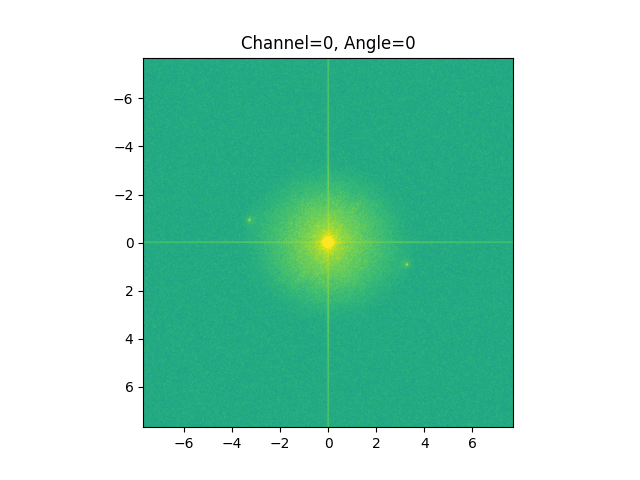

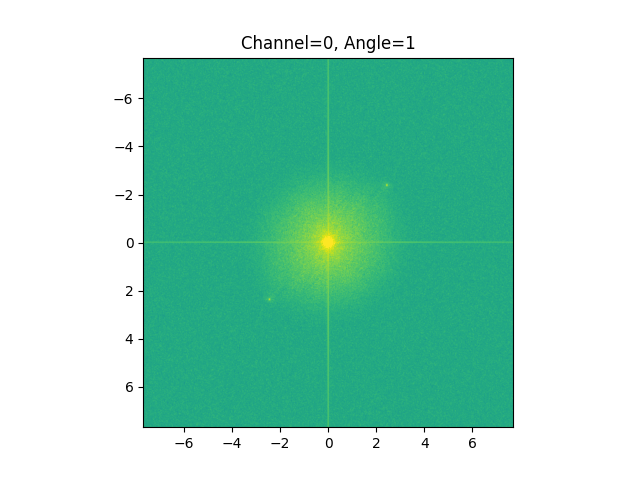

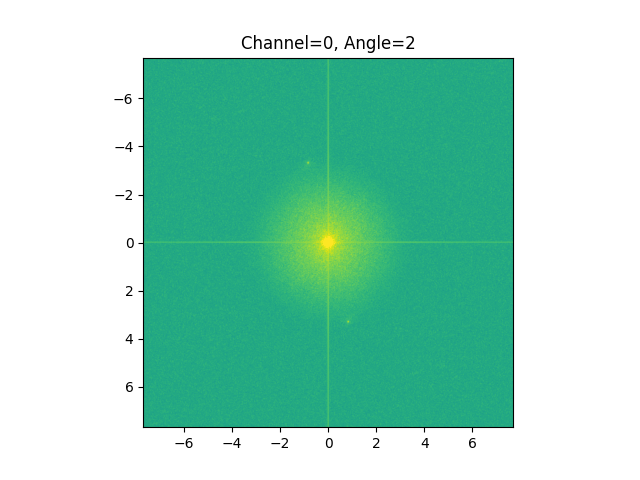

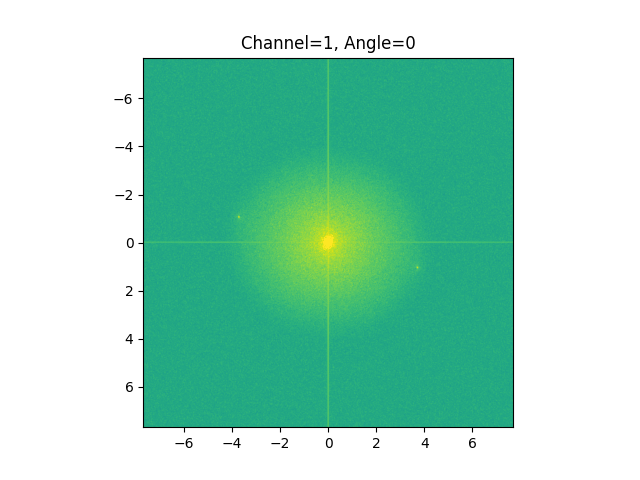

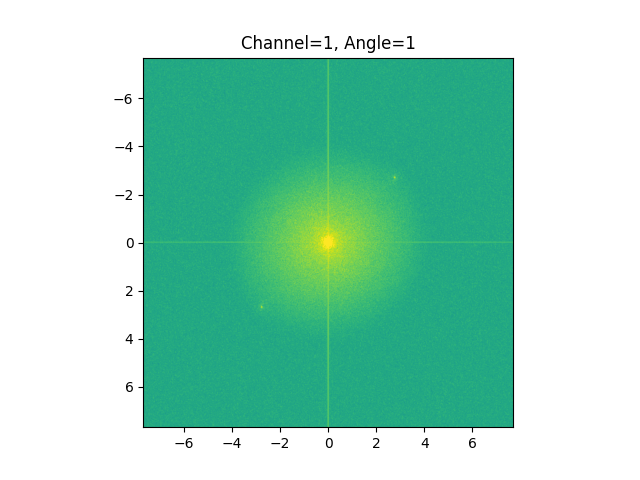

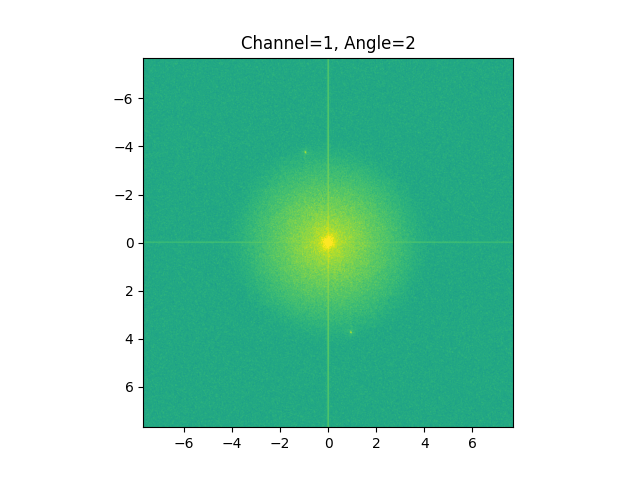

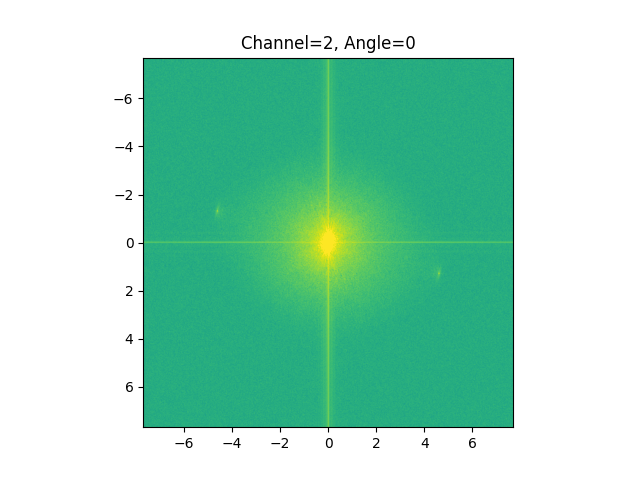

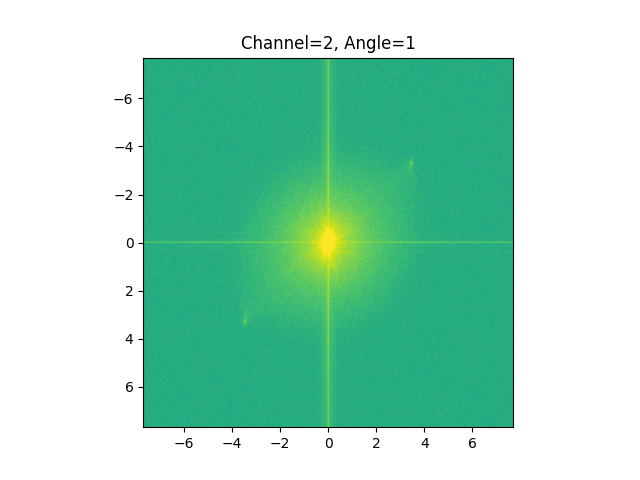

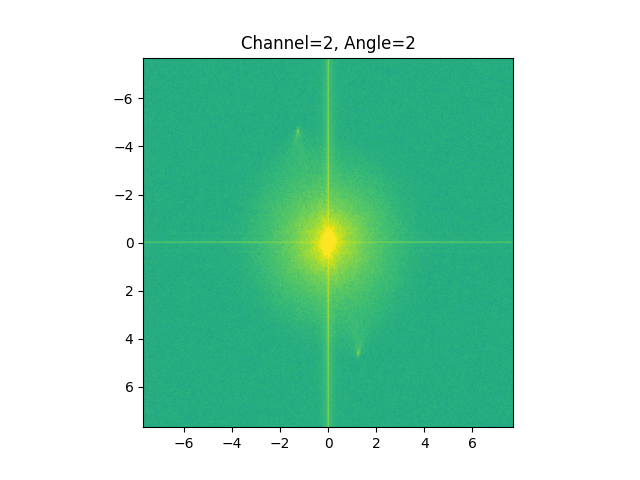

In [5]:
%matplotlib widget
z_idx=0
for ch_idx in range(n_channels):

    image_set = sim_images[ch_idx,:,:,z_idx,:,:]

    dx = np.round(pixel_size_ch_um[ch_idx,1],3)
    nx = n_xpixels
    ny = n_ypixels
    fxs = analysis_tools.get_fft_frqs(nx, dx)
    df = fxs[1] - fxs[0]
    fys = analysis_tools.get_fft_frqs(ny, dx)
    ff = np.sqrt(np.expand_dims(fxs, axis=0)**2 + np.expand_dims(fys, axis=1)**2)
    for ii in range(image_set.shape[0]):
        ft = fft.fftshift(fft.fft2(fft.ifftshift(np.squeeze(image_set[ii, 0, :]))))

        figh = plt.figure()
        plt.title('Channel='+str(ch_idx)+", Angle="+str(ii))
        plt.imshow(np.abs(ft), norm=PowerNorm(gamma=0.1,vmin=65,vmax=1.5e7),
                    extent=[fxs[0] - 0.5 * df, fxs[-1] + 0.5 * df, fys[-1] + 0.5 * df, fys[0] - 0.5 * df])
        plt.show()

### Define guesses for phases and frequencies

In [6]:
# phases
phases_ch =[]
phases_ch.append([[0, 4*np.pi/3, 2*np.pi/3],[0, 4*np.pi/3, 2*np.pi/3],[0, 4*np.pi/3, 2*np.pi/3]]) # ch 0
phases_ch.append([[0, 4*np.pi/3, 2*np.pi/3],[0, 4*np.pi/3, 2*np.pi/3],[0, 4*np.pi/3, 2*np.pi/3]]) # ch 1
phases_ch.append([[0, 4*np.pi/3, 2*np.pi/3],[0, 4*np.pi/3, 2*np.pi/3],[0, 4*np.pi/3, 2*np.pi/3]]) # ch 2

# frequencies
frequencies_ch = []
frequencies_ch.append([[-3.3,-0.92], [-2.4,2.4], [-.85,-3.3]]) # ch 0
frequencies_ch.append([[-3.7,-1.1], [-2.76,2.7], [-.95,-3.7]]) # ch 1
frequencies_ch.append([[-4.6,-1.3], [-3.45,3.3], [-1.2,-4.6]]) # ch 2

In [37]:
wiener_parameter=[0.4,.4,.4]
band0_exclusion_fraction=[0.5,0.5,0.5]
backgrounds = [100,100,100]


### Perform SIM reconstruction

In [38]:
save_path = Path("data","example_004","reconstruction")
for ch_idx in range(n_channels):
    for z_idx in range(n_z_steps):
        physical_params = {'pixel_size': np.round(pixel_size_ch_um[ch_idx,1],3),
                                        'na': NA_ch[ch_idx],
                                        'wavelength': wvl_ch_um[ch_idx]}
        sim_individual_channel = sim_images[ch_idx,:,:,z_idx,:,:]
        imgset = sim.SimImageSet(physical_params,
                                sim_individual_channel,
                                frq_guess=frequencies_ch[ch_idx],
                                phases_guess=phases_ch[ch_idx],
                                determine_amplitudes=True,
                                wiener_parameter=wiener_parameter[ch_idx],
                                fmax_exclude_band0=band0_exclusion_fraction[ch_idx],
                                phase_estimation_mode="real-space",
                                gain=1,
                                background=backgrounds[ch_idx],
                                min_p2nr=0.9,
                                max_phase_err=30*np.pi/180,
                                save_dir=save_path,
                                save_suffix='_z'+str(z_idx).zfill(3)+'_ch'+str(ch_idx).zfill(3))

        imgset.reconstruct()
        imgset.plot_figs()
        imgset.save_imgs()
        imgset.log_file.close()

        if ch_idx == 0 and z_idx == 0:
            wf_images = np.zeros((n_channels,n_z_steps,imgset.widefield.shape[0],imgset.widefield.shape[1]),dtype=np.float32)
            SR_images = np.zeros((n_channels,n_z_steps,imgset.sim_sr.shape[0],imgset.sim_sr.shape[1]),dtype=np.float32)
        wf_images[ch_idx,z_idx,:]=imgset.widefield
        SR_images[ch_idx,z_idx,:]=imgset.sim_sr

        del sim_individual_channel, imgset

####################################################################################
2022/04/29 11:04:44
####################################################################################
Normalizing histograms took 1.62s
FT images took 0.50s
Computing widefield image took 0.48s
Computing SIM-OS image took 0.17s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.8s finished


estimating 3 frequencies took 13.64s using mode 'band-correlation'
estimated peak-to-noise ratio in 0.40s
estimated modulation-contrast-to-noise ratio in 0.63s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    1.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.8s finished


estimated 9 phases in 2.39s using mode 'real-space'
separated bands in 0.25s
estimated noise in 0.32s
shifted bands in 4.55s
shifted otfs in 0.89s
estimated global phases and mod depths in 1.17s
computed band weights in 2.91s
combining bands using mode 'fairSIM' and Wiener parameter 0.400 took 2.21s
Deconvolved widefield in 0.81s
SIM reconstruction for 3 angles and 3 phases
images are size 1024x1024 with pixel size 0.065um
emission wavelength=690nm and NA=1.49
'band-correlation' frequency estimation mode
'real-space' phase estimation mode
'fairSIM' band combination mode
excluded 0.50 from bands around centers
wiener parameter = 0.40
################ Angle 0 ################
relative intensity to max angle = 1.000
phase relative intensities = 1.000, 0.974, 0.963, 
amps = 1.000, 1.000, 1.000
peak-to-camera-noise ratios = 15.958, 16.275, 15.979
modulation depth = 0.161
Frequency guess= (-3.30000, -0.92000), period=291.899nm, angle=-164.422deg
Frequency fit  = (-3.30039, -0.90560), period=

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.5s finished


estimating 3 frequencies took 14.26s using mode 'band-correlation'
estimated peak-to-noise ratio in 0.34s
estimated modulation-contrast-to-noise ratio in 0.59s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.3s finished


estimated 9 phases in 1.92s using mode 'real-space'
separated bands in 0.16s
estimated noise in 0.32s
shifted bands in 4.01s
shifted otfs in 0.89s
estimated global phases and mod depths in 1.00s
computed band weights in 2.60s
combining bands using mode 'fairSIM' and Wiener parameter 0.400 took 2.16s
Deconvolved widefield in 0.85s
SIM reconstruction for 3 angles and 3 phases
images are size 1024x1024 with pixel size 0.065um
emission wavelength=600nm and NA=1.49
'band-correlation' frequency estimation mode
'real-space' phase estimation mode
'fairSIM' band combination mode
excluded 0.50 from bands around centers
wiener parameter = 0.40
################ Angle 0 ################
relative intensity to max angle = 1.000
phase relative intensities = 1.000, 0.973, 0.963, 
amps = 1.000, 1.000, 1.000
peak-to-camera-noise ratios = 131.912, 131.570, 133.261
modulation depth = 0.780
Frequency guess= (-3.70000, -1.10000), period=259.064nm, angle=-163.443deg
Frequency fit  = (-3.71362, -1.05132), peri

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.6s finished


estimating 3 frequencies took 11.44s using mode 'band-correlation'
estimated peak-to-noise ratio in 0.31s
estimated modulation-contrast-to-noise ratio in 0.57s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.9s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.4s finished


estimated 9 phases in 2.06s using mode 'real-space'
separated bands in 0.21s
estimated noise in 0.35s
shifted bands in 4.23s
shifted otfs in 1.00s
estimated global phases and mod depths in 1.41s
computed band weights in 2.70s
combining bands using mode 'fairSIM' and Wiener parameter 0.400 took 2.34s
Deconvolved widefield in 0.79s
SIM reconstruction for 3 angles and 3 phases
images are size 1024x1024 with pixel size 0.065um
emission wavelength=520nm and NA=1.49
'band-correlation' frequency estimation mode
'real-space' phase estimation mode
'fairSIM' band combination mode
excluded 0.50 from bands around centers
wiener parameter = 0.40
################ Angle 0 ################
relative intensity to max angle = 0.998
phase relative intensities = 1.000, 0.978, 0.977, 
amps = 1.000, 1.000, 1.000
peak-to-camera-noise ratios = 44.254, 44.172, 44.611
modulation depth = 0.415
Frequency guess= (-4.60000, -1.30000), period=209.198nm, angle=-164.219deg
Frequency fit  = (-4.60721, -1.30359), period=

### Display results

In [39]:
colormaps = ['bop purple', 'bop blue', 'bop orange']

for ch_idx in range(n_channels):
    if ch_idx == 0:
        viewer = napari.view_image(wf_images[ch_idx,:],name='Widefield CH '+str(ch_idx).zfill(2),scale=(pixel_size_ch_um[ch_idx,1],pixel_size_ch_um[ch_idx,2]),colormap = colormaps[ch_idx],blending='additive',contrast_limits=[0,2**16-1])
        viewer.add_image(SR_images[ch_idx,:],name='SR CH '+str(ch_idx).zfill(2),scale=(pixel_size_ch_um[ch_idx,1]/2,pixel_size_ch_um[ch_idx,2]/2),colormap = colormaps[ch_idx],blending='additive',contrast_limits=[0,2**16-1])
    else:
        viewer.add_image(wf_images[ch_idx,:],name='Widefield CH '+str(ch_idx).zfill(2),scale=(pixel_size_ch_um[ch_idx,1],pixel_size_ch_um[ch_idx,2]),colormap = colormaps[ch_idx],blending='additive',contrast_limits=[0,2**16-1])
        viewer.add_image(SR_images[ch_idx,:],name='SR CH '+str(ch_idx).zfill(2),scale=(pixel_size_ch_um[ch_idx,1]/2,pixel_size_ch_um[ch_idx,2]/2),colormap = colormaps[ch_idx],blending='additive',contrast_limits=[0,2**16-1])

viewer.scale_bar.unit = 'um'
viewer.scale_bar.visible = True

Exception in callback BaseAsyncIOLoop._handle_events(12956, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(12956, 1)>
Traceback (most recent call last):
  File "C:\Users\dpshe\miniconda3\envs\mcsimi2k\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dpshe\miniconda3\envs\mcsimi2k\lib\site-packages\tornado\platform\asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\dpshe\miniconda3\envs\mcsimi2k\lib\site-packages\zmq\eventloop\zmqstream.py", line 452, in _handle_events
    self._handle_recv()
  File "C:\Users\dpshe\miniconda3\envs\mcsimi2k\lib\site-packages\zmq\eventloop\zmqstream.py", line 481, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\dpshe\miniconda3\envs\mcsimi2k\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\dpshe\miniconda3\envs\mcsimi2k\lib\site-packages\jupyter_client\threade